# Primary Model Pipeline

In [11]:
import collections
import pandas as pd
import numpy as np
import time
import os
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from scipy import signal
pd.set_option('display.max_columns', 500)

In [12]:
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [13]:
tf.__version__

'1.13.1'

### Load Datasets and Clean
In this configuration the relevant data set should be loaded from the same folder as the notebook

In [14]:
df = pd.read_csv('/nfs/2018/j/jcruz-y-/neurotron_datasets/joined/joined_data_106979_24-Oct-19_17:31_jose_all_1.csv')

The data consists of timestamps from the two hardware devices and a diff between them. When the two hardware data streams were stitched together an effor was made to minimize this diff, but the driver configuration did not easily permit eliminating it. This information is included to understand the accuracy of the data, but will not be used during the training.

The time data is followed by the 8 channels from the Myo, this data will be used as input features.

This is followed by the 63 positional points from the Leap cameras. These will be used as labels.

In [15]:
df.head()

,Leap timestamp,timestamp diff,emg timestamp,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Wrist x,Wrist y,Wrist z,Thumb Proximal x,Thumb Proximal y,Thumb Proximal z,Thumb Intermediate x,Thumb Intermediate y,Thumb Intermediate z,Thumb Distal x,Thumb Distal y,Thumb Distal z,Thumb Tip x,Thumb Tip y,Thumb Tip z,Index Proximal x,Index Proximal y,Index Proximal z,Index Intermediate x,Index Intermediate y,Index Intermediate z,Index Distal x,Index Distal y,Index Distal z,Index Tip x,Index Tip y,Index Tip z,Middle Proximal x,Middle Proximal y,Middle Proximal z,Middle Intermediate x,Middle Intermediate y,Middle Intermediate z,Middle Distal x,Middle Distal y,Middle Distal z,Middle Tip x,Middle Tip y,Middle Tip z,Ring Proximal x,Ring Proximal y,Ring Proximal z,Ring Intermediate x,Ring Intermediate y,Ring Intermediate z,Ring Distal x,Ring Distal y,Ring Distal z,Ring Tip x,Ring Tip y,Ring Tip z,Pinky Proximal x,Pinky Proximal y,Pinky Proximal z,Pinky Intermediate x,Pinky Intermediate y,Pinky Intermediate z,Pinky Distal x,Pinky Distal y,Pinky Distal z,Pinky Tip x,Pinky Tip y,Pinky Tip z
0,1.571891e+09,0.006226,1.571891e+09,50.0,250.0,396.0,89.0,53.0,43.0,31.0,61.0,9.262085,-9.118690,47.617905,-18.114399,-8.678528,51.673462,-46.709621,-12.567474,17.094170,-69.877258,-11.163055,-3.096992,-85.138763,-10.990265,-17.690151,-20.603283,15.033867,-19.298096,-18.594982,29.675285,-55.134228,-23.628544,21.952751,-74.898529,-29.280987,9.089638,-81.241966,-1.600807,9.199806,-21.184177,9.602978,22.597313,-61.013245,5.366776,12.613152,-84.265617,-2.429310,-1.073235,-90.542023,16.659401,0.454193,-17.607121,31.992260,15.967636,-51.509766,30.006121,9.053932,-75.447060,22.099865,-3.387665,-83.625824,31.320591,-11.242180,-12.971455,48.320904,0.762253,-37.152554,49.054413,-1.940414,-54.576313,42.004250,-10.960121,-65.103134
1,1.571891e+09,-0.029152,1.571891e+09,50.0,286.0,368.0,74.0,51.0,29.0,23.0,42.0,6.786233,-11.333852,47.534789,-20.769446,-11.812599,49.990927,-48.818829,-12.573416,14.808353,-71.526649,-9.472275,-5.685904,-86.040143,-8.497499,-20.978106,-19.892583,15.473871,-19.684725,-16.363919,31.977931,-54.562784,-20.061439,25.205292,-74.945980,-24.964155,12.585976,-82.297033,-0.656441,10.240284,-20.741277,12.169991,25.430847,-59.404511,9.774177,16.861857,-83.445555,3.000662,3.609998,-91.510464,17.612489,1.798022,-16.543760,34.630843,19.197273,-48.656146,34.708936,13.781877,-73.032392,28.021311,1.851053,-82.843496,32.317179,-9.737174,-11.650706,50.569850,3.507205,-34.192403,52.642263,1.569894,-51.594506,46.731619,-7.074512,-63.067226
2,1.571891e+09,0.001225,1.571891e+09,48.0,270.0,347.0,69.0,50.0,29.0,22.0,37.0,5.317806,-12.499672,47.453987,-22.304150,-13.473961,48.934364,-50.567093,-11.620216,13.915695,-73.125786,-7.157860,-6.519272,-87.022034,-5.696548,-22.351597,-19.449600,15.688126,-19.963085,-15.181034,33.082428,-54.341133,-18.064960,27.075287,-75.106461,-22.477337,14.810486,-83.337776,-0.101135,10.783897,-20.485744,13.475960,26.486450,-58.701767,12.304794,18.931656,-83.193710,6.364304,6.209526,-92.698830,18.149715,2.515739,-15.874870,36.093548,20.546936,-47.148628,37.534588,16.020477,-71.687836,31.792110,4.564583,-82.641403,32.863037,-8.918983,-10.774841,52.029774,4.644127,-32.373928,55.188416,3.101257,-49.667633,50.315052,-5.215370,-61.872467
3,1.571891e+09,0.009088,1.571891e+09,49.0,245.0,326.0,66.0,39.0,28.0,23.0,36.0,5.141285,-12.493469,47.475067,-22.483795,-13.559532,48.828407,-50.828781,-11.390457,13.894257,-73.361900,-6.804001,-6.541451,-87.106232,-5.372879,-22.508564,-19.409599,15.628494,-20.048607,-15.110043,33.002945,-54.432831,-17.841034,27.203735,-75.277794,-22.137730,15.102798,-83.807457,-0.042805,10.788460,-20.483543,13.552137,26.346481,-58.752304,12.602261,18.943726,-83.300186,6.865059,6.356377,-93.104897,18.213963,2.579636,-15.790806,36.240501,20.540024,-47.057739,37.922184,16.111511,-71.599510,32.396820,4.750542,-82.761627,32.941494,-8.807564,-10.625877,52.218910,4.702339,-32.159714,55.573746,3.183128,-49.418533,50.933563,-5.084938,-61.746620
4,1

In [16]:
df = df.drop(labels=["Leap timestamp", "timestamp diff", "emg timestamp"], axis=1)

In [17]:
df.describe()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Wrist x,Wrist y,Wrist z,Thumb Proximal x,Thumb Proximal y,Thumb Proximal z,Thumb Intermediate x,Thumb Intermediate y,Thumb Intermediate z,Thumb Distal x,Thumb Distal y,Thumb Distal z,Thumb Tip x,Thumb Tip y,Thumb Tip z,Index Proximal x,Index Proximal y,Index Proximal z,Index Intermediate x,Index Intermediate y,Index Intermediate z,Index Distal x,Index Distal y,Index Distal z,Index Tip x,Index Tip y,Index Tip z,Middle Proximal x,Middle Proximal y,Middle Proximal z,Middle Intermediate x,Middle Intermediate y,Middle Intermediate z,Middle Distal x,Middle Distal y,Middle Distal z,Middle Tip x,Middle Tip y,Middle Tip z,Ring Proximal x,Ring Proximal y,Ring Proximal z,Ring Intermediate x,Ring Intermediate y,Ring Intermediate z,Ring Distal x,Ring Distal y,Ring Distal z,Ring Tip x,Ring Tip y,Ring Tip z,Pinky Proximal x,Pinky Proximal y,Pinky Proximal z,Pinky Intermediate x,Pinky Intermediate y,Pinky Intermediate z,Pinky Distal x,Pinky Distal y,Pinky Distal z,Pinky Tip x,Pinky Tip y,Pinky Tip z
count,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000
mean,107.959076,277.776554,293.447060,112.697202,55.729031,72.685406,82.720188,67.966208,-1.519532,-9.021946,44.597009,-24.352507,-18.957473,39.809937,-35.202575,-26.591242,2.103636,-40.789788,-32.012339,-22.847791,-44.154327,-35.382372,-37.740631,-16.995893,7.373415,-23.683015,-14.404202,3.981787,-54.751712,-13.055133,-3.578775,-67.611467,-12.313513,-10.208400,-73.972310,0.712549,9.388218,-19.306369,9.581468,4.679483,-53.065222,12.692946,-4.684326,-67.946889,13.756485,-12.317275,-74.908446,17.529791,8.095233,-10.276684,25.648988,-0.778659,-40.999281,27.275005,-12.593958,-54.669632,27.006531,-21.898478,-60.856092,32.352225,2.837640,-1.285509,41.970822,-4.485664,-24.370822,43.496761,-12.840841,-34.176921,42.845118,-21.385414,-40.369203
std,94.478903,183.819378,181.553457,80.348375,68.751875,110.614351,137.870160,103.867191,18.203014,13.902148,5.902738,17.833762,17.313549,12.854626,10.539880,13.674356,17.937670,20.180079,18.120903,22.667319,30.208039,23.253477,26.870641,9.447936,7.232516,7.711189,22.331166,23.019437,11.387768,28.566881,33.673159,18.030049,32.359781,40.269171,25.337680,8.255159,6.050276,3.587558,22.631948,25.144259,10.117039,30.242326,37.583324,18.901129,34.760672,44.641463,27.063839,5.532313,7.853489,8.013560,18.961775,22.917322,13.537246,27.110144,33.080043,21.107323,32.277698,38.685426,28.408468,4.083498,11.077100,13.504016,14.765910,20.311902,18.142483,21.859076,26.318486,21.132027,28.005897,30.720860,25.151496
min,18.000000,20.000000,22.000000,20.000000,17.000000,16.000000,15.000000,15.000000,-49.460617,-51.661484,-8.476379,-59.220070,-58.296936,-27.315063,-70.195053,-71.954811,-49.751572,-92.561234,-90.297638,-74.886850,-112.754237,-103.504150,-94.854360,-35.338264,-31.792175,-35.444645,-69.852450,-67.396919,-74.289215,-85.011714,-87.236955,-96.546054,-97.884471,-102.978952,-112.462585,-24.145329,-21.980112,-25.657837,-54.249256,-65.532608,-72.724304,-75.109543,-91.424866,-100.599316,-91.211243,-109.174942,-118.985

In [18]:
df = df[:20000]
df.shape

(20000, 71)

### FFT
**Transforming to spectrograms**

In [19]:
# y axis corresponds to frequencies (units are hz?)
# x axis corresponds to times (units are samples?)
# Each square corresponds to the magnitude (the absolute value the wave differs from 0)
shape = (6, 21, 8)
flat_dim = shape[0]*shape[1]*shape[2]
nperseg = 10
noverlap = 8
reshape = (-1, shape[0], shape[1], shape[2])
j = 0
i = 0
dir_num = 0
df_train_g = pd.DataFrame()

frequencies (7,)
times (13,)
spec_shape: (7, 13)
frequencies_shape: (7,)
times_shape: (13,)


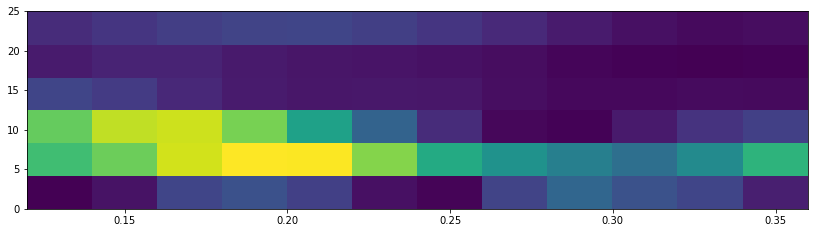

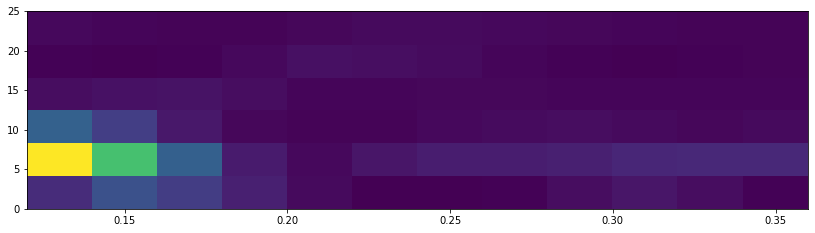

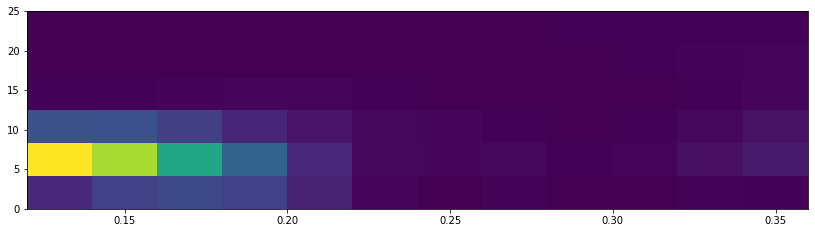

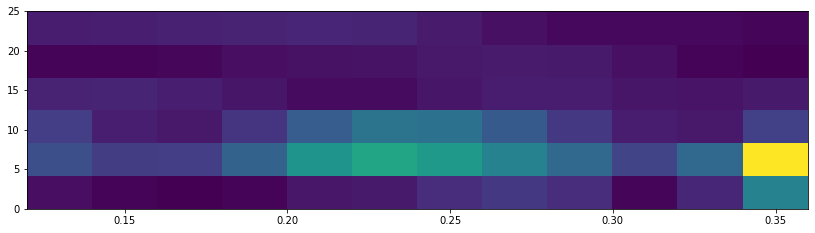

In [20]:
#Spectrogram hyperparameters
nperseg=12 #increasing nperseg increases frequency resolution and decreases time res
noverlap=11 #increasing time resolution requires increasing overlap
window = 'hann' #hann provides good time and frequency resolution properties

#Spectrogram
frequencies, times, spec = signal.spectrogram(x=df['ch1'][:24],
                                              fs=50, nperseg=nperseg,
                                              noverlap=noverlap, window=window)
print('frequencies', frequencies.shape)
print('times', times.shape)
#print(spec)
#Subplot 1
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.show

#Subplot 2
frequencies, times, spec = signal.spectrogram(x=df['ch2'][:24], fs=50, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.show

#Subplot 3
frequencies, times, spec = signal.spectrogram(x=df['ch3'][:24], fs=50, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.show

#Subplot 4
frequencies, times, spec = signal.spectrogram(x=df['ch4'][:24], fs=50, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.show

#Specs and Shapes
#print('label:', label_dir)
#print('file:', file)
print('spec_shape:', spec.shape)
print('frequencies_shape:', frequencies.shape)
print('times_shape:', times.shape)

In [21]:
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8']
shape = (7, 13, 8)
flat_dim = shape[0]*shape[1]*shape[2]
nperseg = 12
noverlap = 11
reshape = (-1, shape[0], shape[1], shape[2])
j = 1
i = 0
dir_num = 0
df_train_g = pd.DataFrame()

img = np.zeros(shape)
k = 0
num_samples = len(df)
x_shape = (num_samples, 7, 13, 8)
x1_train = np.zeros(x_shape)

for i in range(len(df) - 24):
    for j in range(8):
        frequencies, times, spec = signal.spectrogram(x=df[channels[j]][k:k+24], fs=50,
                                                  nperseg=nperseg, noverlap=noverlap,
                                                  window='hann')
        log_spec = np.log(spec)
        img[:,:,j] = spec
        j = j + 1
    x1_train[i,:,:,:] = img
    i = i + 1
    k = k + 1
    if i == 4457:
        print(df.iloc[i,:])
    print(i)
print(x1_train.shape)
flat = np.reshape(x1_train, (num_samples, flat_dim))
df_train1 = pd.DataFrame(data=flat)
df_train_g = df_train_g.append(df_train1, ignore_index=True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


/nfs/2018/j/jcruz-y-/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433


2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937
2938
2939
2940
2941
2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073


4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674


6123
6124
6125
6126
6127
6128
6129
6130
6131
6132
6133
6134
6135
6136
6137
6138
6139
6140
6141
6142
6143
6144
6145
6146
6147
6148
6149
6150
6151
6152
6153
6154
6155
6156
6157
6158
6159
6160
6161
6162
6163
6164
6165
6166
6167
6168
6169
6170
6171
6172
6173
6174
6175
6176
6177
6178
6179
6180
6181
6182
6183
6184
6185
6186
6187
6188
6189
6190
6191
6192
6193
6194
6195
6196
6197
6198
6199
6200
6201
6202
6203
6204
6205
6206
6207
6208
6209
6210
6211
6212
6213
6214
6215
6216
6217
6218
6219
6220
6221
6222
6223
6224
6225
6226
6227
6228
6229
6230
6231
6232
6233
6234
6235
6236
6237
6238
6239
6240
6241
6242
6243
6244
6245
6246
6247
6248
6249
6250
6251
6252
6253
6254
6255
6256
6257
6258
6259
6260
6261
6262
6263
6264
6265
6266
6267
6268
6269
6270
6271
6272
6273
6274
6275
6276
6277
6278
6279
6280
6281
6282
6283
6284
6285
6286
6287
6288
6289
6290
6291
6292
6293
6294
6295
6296
6297
6298
6299
6300
6301
6302
6303
6304
6305
6306
6307
6308
6309
6310
6311
6312
6313
6314
6315
6316
6317
6318
6319
6320
6321
6322


7763
7764
7765
7766
7767
7768
7769
7770
7771
7772
7773
7774
7775
7776
7777
7778
7779
7780
7781
7782
7783
7784
7785
7786
7787
7788
7789
7790
7791
7792
7793
7794
7795
7796
7797
7798
7799
7800
7801
7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813
7814
7815
7816
7817
7818
7819
7820
7821
7822
7823
7824
7825
7826
7827
7828
7829
7830
7831
7832
7833
7834
7835
7836
7837
7838
7839
7840
7841
7842
7843
7844
7845
7846
7847
7848
7849
7850
7851
7852
7853
7854
7855
7856
7857
7858
7859
7860
7861
7862
7863
7864
7865
7866
7867
7868
7869
7870
7871
7872
7873
7874
7875
7876
7877
7878
7879
7880
7881
7882
7883
7884
7885
7886
7887
7888
7889
7890
7891
7892
7893
7894
7895
7896
7897
7898
7899
7900
7901
7902
7903
7904
7905
7906
7907
7908
7909
7910
7911
7912
7913
7914
7915
7916
7917
7918
7919
7920
7921
7922
7923
7924
7925
7926
7927
7928
7929
7930
7931
7932
7933
7934
7935
7936
7937
7938
7939
7940
7941
7942
7943
7944
7945
7946
7947
7948
7949
7950
7951
7952
7953
7954
7955
7956
7957
7958
7959
7960
7961
7962


9442
9443
9444
9445
9446
9447
9448
9449
9450
9451
9452
9453
9454
9455
9456
9457
9458
9459
9460
9461
9462
9463
9464
9465
9466
9467
9468
9469
9470
9471
9472
9473
9474
9475
9476
9477
9478
9479
9480
9481
9482
9483
9484
9485
9486
9487
9488
9489
9490
9491
9492
9493
9494
9495
9496
9497
9498
9499
9500
9501
9502
9503
9504
9505
9506
9507
9508
9509
9510
9511
9512
9513
9514
9515
9516
9517
9518
9519
9520
9521
9522
9523
9524
9525
9526
9527
9528
9529
9530
9531
9532
9533
9534
9535
9536
9537
9538
9539
9540
9541
9542
9543
9544
9545
9546
9547
9548
9549
9550
9551
9552
9553
9554
9555
9556
9557
9558
9559
9560
9561
9562
9563
9564
9565
9566
9567
9568
9569
9570
9571
9572
9573
9574
9575
9576
9577
9578
9579
9580
9581
9582
9583
9584
9585
9586
9587
9588
9589
9590
9591
9592
9593
9594
9595
9596
9597
9598
9599
9600
9601
9602
9603
9604
9605
9606
9607
9608
9609
9610
9611
9612
9613
9614
9615
9616
9617
9618
9619
9620
9621
9622
9623
9624
9625
9626
9627
9628
9629
9630
9631
9632
9633
9634
9635
9636
9637
9638
9639
9640
9641


10911
10912
10913
10914
10915
10916
10917
10918
10919
10920
10921
10922
10923
10924
10925
10926
10927
10928
10929
10930
10931
10932
10933
10934
10935
10936
10937
10938
10939
10940
10941
10942
10943
10944
10945
10946
10947
10948
10949
10950
10951
10952
10953
10954
10955
10956
10957
10958
10959
10960
10961
10962
10963
10964
10965
10966
10967
10968
10969
10970
10971
10972
10973
10974
10975
10976
10977
10978
10979
10980
10981
10982
10983
10984
10985
10986
10987
10988
10989
10990
10991
10992
10993
10994
10995
10996
10997
10998
10999
11000
11001
11002
11003
11004
11005
11006
11007
11008
11009
11010
11011
11012
11013
11014
11015
11016
11017
11018
11019
11020
11021
11022
11023
11024
11025
11026
11027
11028
11029
11030
11031
11032
11033
11034
11035
11036
11037
11038
11039
11040
11041
11042
11043
11044
11045
11046
11047
11048
11049
11050
11051
11052
11053
11054
11055
11056
11057
11058
11059
11060
11061
11062
11063
11064
11065
11066
11067
11068
11069
11070
11071
11072
11073
11074
11075
11076
1107

12321
12322
12323
12324
12325
12326
12327
12328
12329
12330
12331
12332
12333
12334
12335
12336
12337
12338
12339
12340
12341
12342
12343
12344
12345
12346
12347
12348
12349
12350
12351
12352
12353
12354
12355
12356
12357
12358
12359
12360
12361
12362
12363
12364
12365
12366
12367
12368
12369
12370
12371
12372
12373
12374
12375
12376
12377
12378
12379
12380
12381
12382
12383
12384
12385
12386
12387
12388
12389
12390
12391
12392
12393
12394
12395
12396
12397
12398
12399
12400
12401
12402
12403
12404
12405
12406
12407
12408
12409
12410
12411
12412
12413
12414
12415
12416
12417
12418
12419
12420
12421
12422
12423
12424
12425
12426
12427
12428
12429
12430
12431
12432
12433
12434
12435
12436
12437
12438
12439
12440
12441
12442
12443
12444
12445
12446
12447
12448
12449
12450
12451
12452
12453
12454
12455
12456
12457
12458
12459
12460
12461
12462
12463
12464
12465
12466
12467
12468
12469
12470
12471
12472
12473
12474
12475
12476
12477
12478
12479
12480
12481
12482
12483
12484
12485
12486
1248

13731
13732
13733
13734
13735
13736
13737
13738
13739
13740
13741
13742
13743
13744
13745
13746
13747
13748
13749
13750
13751
13752
13753
13754
13755
13756
13757
13758
13759
13760
13761
13762
13763
13764
13765
13766
13767
13768
13769
13770
13771
13772
13773
13774
13775
13776
13777
13778
13779
13780
13781
13782
13783
13784
13785
13786
13787
13788
13789
13790
13791
13792
13793
13794
13795
13796
13797
13798
13799
13800
13801
13802
13803
13804
13805
13806
13807
13808
13809
13810
13811
13812
13813
13814
13815
13816
13817
13818
13819
13820
13821
13822
13823
13824
13825
13826
13827
13828
13829
13830
13831
13832
13833
13834
13835
13836
13837
13838
13839
13840
13841
13842
13843
13844
13845
13846
13847
13848
13849
13850
13851
13852
13853
13854
13855
13856
13857
13858
13859
13860
13861
13862
13863
13864
13865
13866
13867
13868
13869
13870
13871
13872
13873
13874
13875
13876
13877
13878
13879
13880
13881
13882
13883
13884
13885
13886
13887
13888
13889
13890
13891
13892
13893
13894
13895
13896
1389

15114
15115
15116
15117
15118
15119
15120
15121
15122
15123
15124
15125
15126
15127
15128
15129
15130
15131
15132
15133
15134
15135
15136
15137
15138
15139
15140
15141
15142
15143
15144
15145
15146
15147
15148
15149
15150
15151
15152
15153
15154
15155
15156
15157
15158
15159
15160
15161
15162
15163
15164
15165
15166
15167
15168
15169
15170
15171
15172
15173
15174
15175
15176
15177
15178
15179
15180
15181
15182
15183
15184
15185
15186
15187
15188
15189
15190
15191
15192
15193
15194
15195
15196
15197
15198
15199
15200
15201
15202
15203
15204
15205
15206
15207
15208
15209
15210
15211
15212
15213
15214
15215
15216
15217
15218
15219
15220
15221
15222
15223
15224
15225
15226
15227
15228
15229
15230
15231
15232
15233
15234
15235
15236
15237
15238
15239
15240
15241
15242
15243
15244
15245
15246
15247
15248
15249
15250
15251
15252
15253
15254
15255
15256
15257
15258
15259
15260
15261
15262
15263
15264
15265
15266
15267
15268
15269
15270
15271
15272
15273
15274
15275
15276
15277
15278
15279
1528

16506
16507
16508
16509
16510
16511
16512
16513
16514
16515
16516
16517
16518
16519
16520
16521
16522
16523
16524
16525
16526
16527
16528
16529
16530
16531
16532
16533
16534
16535
16536
16537
16538
16539
16540
16541
16542
16543
16544
16545
16546
16547
16548
16549
16550
16551
16552
16553
16554
16555
16556
16557
16558
16559
16560
16561
16562
16563
16564
16565
16566
16567
16568
16569
16570
16571
16572
16573
16574
16575
16576
16577
16578
16579
16580
16581
16582
16583
16584
16585
16586
16587
16588
16589
16590
16591
16592
16593
16594
16595
16596
16597
16598
16599
16600
16601
16602
16603
16604
16605
16606
16607
16608
16609
16610
16611
16612
16613
16614
16615
16616
16617
16618
16619
16620
16621
16622
16623
16624
16625
16626
16627
16628
16629
16630
16631
16632
16633
16634
16635
16636
16637
16638
16639
16640
16641
16642
16643
16644
16645
16646
16647
16648
16649
16650
16651
16652
16653
16654
16655
16656
16657
16658
16659
16660
16661
16662
16663
16664
16665
16666
16667
16668
16669
16670
16671
1667

17920
17921
17922
17923
17924
17925
17926
17927
17928
17929
17930
17931
17932
17933
17934
17935
17936
17937
17938
17939
17940
17941
17942
17943
17944
17945
17946
17947
17948
17949
17950
17951
17952
17953
17954
17955
17956
17957
17958
17959
17960
17961
17962
17963
17964
17965
17966
17967
17968
17969
17970
17971
17972
17973
17974
17975
17976
17977
17978
17979
17980
17981
17982
17983
17984
17985
17986
17987
17988
17989
17990
17991
17992
17993
17994
17995
17996
17997
17998
17999
18000
18001
18002
18003
18004
18005
18006
18007
18008
18009
18010
18011
18012
18013
18014
18015
18016
18017
18018
18019
18020
18021
18022
18023
18024
18025
18026
18027
18028
18029
18030
18031
18032
18033
18034
18035
18036
18037
18038
18039
18040
18041
18042
18043
18044
18045
18046
18047
18048
18049
18050
18051
18052
18053
18054
18055
18056
18057
18058
18059
18060
18061
18062
18063
18064
18065
18066
18067
18068
18069
18070
18071
18072
18073
18074
18075
18076
18077
18078
18079
18080
18081
18082
18083
18084
18085
1808

19306
19307
19308
19309
19310
19311
19312
19313
19314
19315
19316
19317
19318
19319
19320
19321
19322
19323
19324
19325
19326
19327
19328
19329
19330
19331
19332
19333
19334
19335
19336
19337
19338
19339
19340
19341
19342
19343
19344
19345
19346
19347
19348
19349
19350
19351
19352
19353
19354
19355
19356
19357
19358
19359
19360
19361
19362
19363
19364
19365
19366
19367
19368
19369
19370
19371
19372
19373
19374
19375
19376
19377
19378
19379
19380
19381
19382
19383
19384
19385
19386
19387
19388
19389
19390
19391
19392
19393
19394
19395
19396
19397
19398
19399
19400
19401
19402
19403
19404
19405
19406
19407
19408
19409
19410
19411
19412
19413
19414
19415
19416
19417
19418
19419
19420
19421
19422
19423
19424
19425
19426
19427
19428
19429
19430
19431
19432
19433
19434
19435
19436
19437
19438
19439
19440
19441
19442
19443
19444
19445
19446
19447
19448
19449
19450
19451
19452
19453
19454
19455
19456
19457
19458
19459
19460
19461
19462
19463
19464
19465
19466
19467
19468
19469
19470
19471
1947

In [28]:
df_train_g.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727
0,0.000553,37.132088,92.929996,1.809599,3.214205,0.488326,0.050895,2.695981,0.309735,74.989292,157.772353,0.481660,2.508703,0.066427,0.013333,1.044501,1.250860,53.645602,184.588765,0.097069,1.104340,0.041318,0.004019,0.584114,1.511481,26.816458,157.622085,0.586795,0.046944,0.030416,0.000766,0.301185,1.165846,8.262185,80.243683,2.766891,0.061903,1.258903e-02,0.000239,0.105236,0.244053,0.424475,15.100695,3.162089,0.152000,1.438461e-02,0.012589,0.040000,0.070940,0.174342,0.316695,5.724055,0.121664,2.349145e-02,0.002967,0.077101,1.229018,1.513058,8.549748,7.142597,0.031994,1.160684e-02,0.002382,0.152000,1.986654,9.841221,2.145975,5.722521,0.002500,2.684318e-31,0.000001,0.215550,1.536487,16.563679,3.059134,0.640513,0.198215,0.011607,0.001786,0.148538,1.263558,10.490537,8.421527,4.732854,0.835310,0.016607,0.001687,0.043154,0.522562,2.365548,5.274578,19.458271,2.227555,0.011350,0.000833,0.000447,0.361052,0.473391,2.505657,47.573424,4.775624,0.106585,0.000397,0.023491,4.228174,299.837296,835.735855,10.643576,5.672005,0.456897,0.017664,5.983358,4.737958,211.633612,727.164565,7.847786,2.900017,0.075356,0.055239,2.711253,5.699363,91.008481,496.290762,8.079651,1.311574,0.054801,0.043892,0.963880,6.113667,21.851774,261.475340,13.990897,0.574510,0.065494,0.037385,0.293174,6.079011,6.804779,92.468415,22.921564,0.579231,0.053432,0.026986,0.346422,4.988461,16.936580,20.448889,25.969909,0.556057,0.054165,0.033217,0.559350,3.714690,24.269598,13.456068,23.873906,0.355350,0.071863,0.011866,0.618338,3.109909,23.807096,17.523363,19.512240,0.106826,0.072974,0.005678,0.575541,2.626410,26.503337,6.518278,14.814876,0.042719,0.069641,0.003692,0.531177,2.202827,32.207438,10.570726,8.910123,0.555187,0.072974,0.004368,0.429792,2.909122,33.164586,33.315746,14.827503,2.364970,0.061130,0.002066,0.335765,3.953531,33.591304,56.787015,44.042190,7.460906,0.016000,0.000657,0.269657,5.937917,34.141654,64.024177,130.187814,20.450819,0.244187,0.000519,0.194122,4.661233,91.876414,212.164161,8.093933,0.948509,0.037954,0.071013,1.166798,5.534288,54.356300,208.287141,3.761022,0.227835,0.016651,0.056427,0.596493,5.

In [23]:
def preprocess_features(x_train):
    shape = (7, 13, 8)
    reshape = (-1, shape[0], shape[1], shape[2])
    x_train = x_train.replace(-np.inf, 0)
    x_train = x_train.replace(np.inf, 0)
    #x_train = np.log(x_train.values)
    x_train = x_train.values
    x_train_norm = x_train.reshape(reshape)
    return x_train_norm

features = preprocess_features(df_train_g)

In [24]:
x1_train.shape

(20000, 7, 13, 8)

In [25]:
features.shape

(20000, 7, 13, 8)

In [26]:
labels = df.loc[:, 'Wrist x':].values

## Conv_LSTM

In [30]:
def create_model(input_shape):
    inputlayer = Input(shape=input_shape)
    
    norm_input = BatchNormalization()(inputlayer)
    model = ConvLSTM2D(32, kernel_size=2, padding='same', activation='relu', return_sequences=True)(norm_input)
    model = Dropout(rate=0.5)(model)
    model = ConvLSTM2D(32, kernel_size=2, padding='same', activation='relu', return_sequences=True)(model)
    model = Dropout(rate=0.5)(model)
    model = ConvLSTM2D(64, kernel_size=2, padding='same', activation='relu', return_sequences=True)(model)
    model = Dropout(rate=0.5)(model)
    model = ConvLSTM2D(64, kernel_size=2, padding='same', activation='relu', return_sequences=False)(model)
    model = Dropout(rate=0.5)(model)
    #model = ConvLSTM2D(128, kernel_size=2, padding='same', activation='relu', return_sequences=True)(model)
    #model = Dropout(rate=0.5)(model)
    #model = ConvLSTM2D(128, kernel_size=2, padding='same', activation='relu', return_sequences=False)(model)
    #model = Dropout(rate=0.5)(model)
    model = Flatten()(model)
    mode1 = BatchNormalization()(Dense(128, activation='relu')(model))
    mode1 = BatchNormalization()(Dense(128, activation='relu')(model))
    model = Dense(63, activation='relu')(model)
    #dense_5 = Dense(63, activation='relu')(model)
    #model = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(model)
    #model = Dropout(rate=0.2)(model)
    #model = ConvLSTM2D(64, kernel_size=3, padding='same', activation='relu')(model)
    #model = ConvLSTM2D(64, kernel_size=3, padding='same', activation='relu')(model)
    #model = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(model)
    #model = Dropout(rate=0.2)(model)
    #model = Conv2D(128, kernel_size=3, padding='same', activation='relu')(model)
    #model = Conv2D(128, kernel_size=3, padding='same', activation='relu')(model)
    #model = TimeDistributed(MaxPooling2D(pool_size=(1, 1)))(model)
    #model = Flatten()(model) 

    #dense_1 = BatchNormalization()(Dense(128, activation='relu')(model))
    #dense_2 = BatchNormalization()(Dense(128, activation='relu')(dense_1))
    #dense_1 = Dense(nclass, activation='softmax')(dense_1)

    #lstm layers
    #inputs = Input(shape=(None, 128), name="inputs")(dense_2)
    #lstm_0 = LSTM(100, return_sequences=True, name="lstm_0")(dense_2)
    #do = Dropout(0.4)(lstm_0)
    #lstm_1 = LSTM(100, return_sequences=True, name="lstm_1")(do)
    #do_2 = Dropout(0.4)(lstm_1)
    #lstm_1 = LSTM(100, return_sequences=False, name="lstm_1")(do_2)
    
    #dense_3 = Dense(128, activation='relu', name="dense_3")(lstm_1)
    #dense_4 = BatchNormalization()(Dense(128, activation='relu')(dense_3))
    #dense_5 = Dense(128, activation='relu')(dense_4)
    #dense_6 = BatchNormalization()(Dense(128, activation='relu')(dense_5))
    #dense_5 = Dense(64, activation='relu')(dense_4)
    
    #model_fc.add(Dense(100, input_dim=64))
    #model_fc.add(Activation('relu'))
    #model_fc.add(BatchNormalization())
    #model_fc.add(Dropout(0.2))
    #model_fc.add(Dense(64, input_dim=64))
    #model_fc.add(Activation('relu'))
    #model_fc.add(Dropout(0.2))
    #model_fc.add(Dense(63, input_dim=64))
    
    #decoder layers
    #decoder_0 = decoder.get_layer("decoder_0")(lstm_out)
    #decoder_0.trainable = False
    #decoder_1 = decoder.get_layer("decoder_1")(decoder_0)
    #decoder_1.trainable = False
    #decoder_output = decoder.get_layer("decoder_output")(decoder_1)
    #decoder_output.trainable = False
    
    model = Model(inputs=inputlayer, outputs=model)
    #model = Model(inputs, decoder_output, name="model_v1")
    return model

shape = (24, 7, 13, 8)
model = create_model(shape)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 24, 7, 13, 8)      0         
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 24, 7, 13, 8)      32        
_________________________________________________________________
conv_lst_m2d_10 (ConvLSTM2D) (None, 24, 7, 13, 32)     20608     
_________________________________________________________________
dropout_10 (Dropout)         (None, 24, 7, 13, 32)     0         
_________________________________________________________________
conv_lst_m2d_11 (ConvLSTM2D) (None, 24, 7, 13, 32)     32896     
_________________________________________________________________
dropout_11 (Dropout)         (None, 24, 7, 13, 32)     0         
_________________________________________________________________
conv_lst_m2d_12 (ConvLSTM2D) (None, 24, 7, 13, 64)     98560     
__________

In [31]:
optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer=optimizer, loss='mse')

Instructions for updating:
Use tf.cast instead.


In [33]:
seq_length = 24

def reshape_overlap_samples(seq_length, feats, labels):
    samples = feats.shape[0] - (seq_length - 1)    # all samples except the last sequence
    shape = (24, 7, 13, 8)
    new_f = np.zeros(shape=(samples, 24, 7, 13, 8))
    print(new_f.shape)
    new_l = labels[seq_length - 1:]
    queue = collections.deque(feats[:seq_length])
    new_f[0] = np.array(queue)
    j = 1
    for i in range(seq_length, feats.shape[0]):
        queue.popleft()
        queue.append(feats[i])
        new_f[j] = np.array(queue)
        j += 1
    return (new_f, new_l)

features_ol, labels_ol = reshape_overlap_samples(seq_length, features, labels)
print(features_ol.shape)
print(labels_ol.shape)

(19977, 24, 7, 13, 8)
(19977, 24, 7, 13, 8)
(19977, 63)


In [34]:
model.evaluate(features_ol, labels_ol, verbose=1)

19977/19977 [==============================] - 398s 20ms/sample - loss: 25183.2709


25183.270899229425

In [35]:
history = model.fit(features_ol, labels_ol, batch_size=seq_length, epochs=4, verbose=1, validation_split=0.2)

Train on 15981 samples, validate on 3996 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/4
15981/15981 [==============================] - 1345s 84ms/sample - loss: 1265.9664 - val_loss: 1079.8588
Epoch 2/4
15981/15981 [==============================] - 1373s 86ms/sample - loss: 1223.0382 - val_loss: 1076.8316
Epoch 3/4
15981/15981 [==============================] - 1440s 90ms/sample - loss: 1221.4506 - val_loss: 1078.6315
Epoch 4/4
15981/15981 [==============================] - 1473s 92ms/sample - loss: 1219.2912 - val_loss: 1095.5899


## CNN + LSTM

In [117]:
def create_model(input_shape):
    inputlayer = Input(shape=input_shape)
    
    norm_input = BatchNormalization()(inputlayer)
    model = Conv2D(32, kernel_size=2, padding='same', activation='relu')(norm_input)
    model = Conv2D(32, kernel_size=2, padding='same', activation='relu')(model)
    model = MaxPooling2D(pool_size=(2, 2))(model)
    model = Dropout(rate=0.2)(model)
    model = Conv2D(64, kernel_size=3, padding='same', activation='relu')(model)
    model = Conv2D(64, kernel_size=3, padding='same', activation='relu')(model)
    model = MaxPooling2D(pool_size=(2, 2))(model)
    model = Dropout(rate=0.2)(model)
    model = Conv2D(128, kernel_size=3, padding='same', activation='relu')(model)
    model = Conv2D(128, kernel_size=3, padding='same', activation='relu')(model)
    model = MaxPooling2D(pool_size=(1, 1))(model)
    model = Flatten()(model) 

    dense_1 = BatchNormalization()(Dense(128, activation='relu')(model))
    dense_2 = BatchNormalization()(Dense(128, activation='relu')(dense_1))
    #dense_1 = Dense(nclass, activation='softmax')(dense_1)
    
    #lstm layers
    #inputs = Input(shape=(None, 128), name="inputs")(dense_2)
    lstm_0 = LSTM(100, return_sequences=True, name="lstm_0")(dense_2)
    do = Dropout(0.4)(lstm_0)
    lstm_1 = LSTM(100, return_sequences=True, name="lstm_1")(do)
    do_2 = Dropout(0.4)(lstm_0)
    lstm_1 = LSTM(100, return_sequences=False, name="lstm_1")(do_2)
    
    dense_3 = Dense(128, activation='relu', name="dense_3")(lstm_1)
    dense_4 = BatchNormalization()(Dense(128, activation='relu')(dense_3))
    dense_5 = Dense(128, activation='relu')(dense_4)
    dense_6 = BatchNormalization()(Dense(128, activation='relu')(dense_5))
    dense_5 = Dense(64, activation='relu')(dense_4)
    
    #model_fc.add(Dense(100, input_dim=64))
    #model_fc.add(Activation('relu'))
    #model_fc.add(BatchNormalization())
    #model_fc.add(Dropout(0.2))
    #model_fc.add(Dense(64, input_dim=64))
    #model_fc.add(Activation('relu'))
    #model_fc.add(Dropout(0.2))
    #model_fc.add(Dense(63, input_dim=64))
    
    #decoder layers
    #decoder_0 = decoder.get_layer("decoder_0")(lstm_out)
    #decoder_0.trainable = False
    #decoder_1 = decoder.get_layer("decoder_1")(decoder_0)
    #decoder_1.trainable = False
    #decoder_output = decoder.get_layer("decoder_output")(decoder_1)
    #decoder_output.trainable = False
    
    model = Model(inputs=inputlayer, outputs=dense_5)
    #model = Model(inputs, decoder_output, name="model_v1")
    return model


model = create_model(shape)

model.summary()

ValueError: Input 0 of layer lstm_0 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 128]

## conv_lstm_2d

In [ ]:
#lstm layers
inputs = Input(shape=(None, 8), name="inputs")
lstm_0 = ConvLSTM2D(100, return_sequences=True, name="lstm_0")(inputs)
do = Dropout(0.4)(lstm_0)
lstm_1 = ConvLSTM2D(100, return_sequences=False, name="lstm_1")(do)
do_2 = Dropout(0.4)(lstm_0)
lstm_1 = ConvLSTM2D(100, return_sequences=False, name="lstm_1")(do_2)
lstm_out = Dense(9, activation=None, name="lstm_out")(lstm_1)

#decoder layers
decoder_0 = decoder.get_layer("decoder_0")(lstm_out)
decoder_0.trainable = False
decoder_1 = decoder.get_layer("decoder_1")(decoder_0)
decoder_1.trainable = False
decoder_output = decoder.get_layer("decoder_output")(decoder_1)
decoder_output.trainable = False

model = Model(inputs, decoder_output, name="model_v1")
optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

## Autoencoder
The final pipeline will pass the data into an LSTM and then into an autoencoder to expand features into the 63 point space. This autoencoder will be trained first below:

In [10]:
feature_ar = df.loc[:, 'ch1':'ch8'].values
label_ar = df.loc[:, 'Wrist x':].values

In [11]:
feature_ar.shape

(388689, 8)

In [12]:
label_ar.shape

(388689, 63)

Build the autoencoder structure:

In [13]:
encoding_dim = 9 #dimensionality of 'feature' vector

a_fn = None

# Full autoencoder
input_vec = Input(shape=(63,))
dense_0 = Dense(32, activation=a_fn)(input_vec)
dense_1 = Dense(16, activation=a_fn)(dense_0)
encoded = Dense(encoding_dim, activation=a_fn)(dense_1)
dense_2 = Dense(32, activation=a_fn, name='decoder_0')(encoded)
dense_3 = Dense(16, activation=a_fn, name='decoder_1')(dense_2)
decoded = Dense(63, activation=a_fn, name='decoder_output')(dense_3)

autoencoder = Model(input_vec, decoded)

# Encoder from autoencoder
encoder = Model(input_vec, encoded)

# Decoder from autoencoder layers
decoder_input = Input(shape=(encoding_dim,), name='encoded_input')
decode_0 = autoencoder.layers[-3](decoder_input)
decode_1 = autoencoder.layers[-2](decode_0)
decode_output = autoencoder.layers[-1](decode_1)
decoder = Model(decoder_input, decode_output, name='decoder')

# Train Autoencoder
optimizer = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 63)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2048      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 153       
_________________________________________________________________
decoder_0 (Dense)            (None, 32)                320       
_________________________________________________________________
decoder_1 (Dense)            (None, 16)                528       
______________________

In [14]:
autoencoder.evaluate(label_ar, label_ar)

388689/388689 [==============================] - 7s 18us/sample - loss: 2207.5073


2207.5072834586113

From the above evaluation the initial untrained loss is around 2500.
Now train the model:

In [15]:
ret = autoencoder.fit(label_ar, label_ar, batch_size=312, epochs=3, verbose=1, validation_split=0.2)

Train on 310951 samples, validate on 77738 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
310951/310951 [==============================] - 4s 12us/sample - loss: 200.0475 - val_loss: 89.1804
Epoch 2/3
310951/310951 [==============================] - 3s 10us/sample - loss: 33.3941 - val_loss: 58.6980
Epoch 3/3
310951/310951 [==============================] - 3s 10us/sample - loss: 21.6241 - val_loss: 44.6303


Now the encoder - decoder pair will be tested seperately for loss:

In [16]:
encoded_vec = encoder.predict(label_ar)
decoded_vec = decoder.predict(encoded_vec)

#compilation is only to enable evaluation
decoder.compile(optimizer='adam', loss='mse')
decoder.evaluate(encoded_vec, label_ar)

388689/388689 [==============================] - 6s 15us/sample - loss: 23.4744


23.47436806180126

In [17]:
print(encoded_vec.shape)
print(decoded_vec.shape)

(388689, 9)
(388689, 63)


## LSTM
Here the lstm will be trained. The 8 channels of sEMG data will be processed by the LSTM, which will return a vector of 9 complex features. These will then be processed by the autoencoder, trained in the previous section, to create the 63 hand coordinates.

To train the sequential recurrent LSTM the data will be grouped into 'sequences' of 24 steps in time. The LSTM will be trained with many sequence groups.

In [18]:
seq_length = 24

def overlap_samples(seq_length, feats, labels):
    new_l = labels[seq_length - 1:]
    feat_list = [feats[i:i + seq_length] for i in range(feats.shape[0] - seq_length + 1)]
    new_f = np.array(feat_list)
    return new_f, new_l

features, labels = overlap_samples(seq_length, feature_ar, label_ar)
print(features.shape)
print(labels.shape)

(388658, 32, 8)
(388658, 63)


In [31]:
#lstm layers
inputs = Input(shape=(None, 8), name="inputs")
lstm_0 = LSTM(100, return_sequences=True, name="lstm_0")(inputs)
do = Dropout(0.4)(lstm_0)
lstm_1 = LSTM(100, return_sequences=False, name="lstm_1")(do)
do_2 = Dropout(0.4)(lstm_0)
lstm_1 = LSTM(100, return_sequences=False, name="lstm_1")(do_2)
lstm_out = Dense(9, activation=None, name="lstm_out")(lstm_1)

#decoder layers
decoder_0 = decoder.get_layer("decoder_0")(lstm_out)
decoder_0.trainable = False
decoder_1 = decoder.get_layer("decoder_1")(decoder_0)
decoder_1.trainable = False
decoder_output = decoder.get_layer("decoder_output")(decoder_1)
decoder_output.trainable = False

model = Model(inputs, decoder_output, name="model_v1")
optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, None, 8)           0         
_________________________________________________________________
lstm_0 (LSTM)                (None, None, 100)         43600     
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
lstm_out (Dense)             (None, 9)                 909       
_________________________________________________________________
decoder_0 (Dense)            (None, 32)                320       
_________________________________________________________________
decoder_1 (Dense)            (None, 16)                528       
__________

In [32]:
model.evaluate(features, labels, verbose=1)

388658/388658 [==============================] - 164s 422us/sample - loss: 731.0006


731.000609906823

In [33]:
history = model.fit(features, labels, batch_size=seq_length, epochs=4, verbose=1, validation_split=0.2)

Train on 310926 samples, validate on 77732 samples
Epoch 1/4
310926/310926 [==============================] - 588s 2ms/sample - loss: 203.7043 - val_loss: 598.5922
Epoch 2/4
310926/310926 [==============================] - 582s 2ms/sample - loss: 154.3962 - val_loss: 596.6076
Epoch 3/4
140448/310926 [============>.................] - ETA: 5:01 - loss: 140.8171

KeyboardInterrupt: 

In [23]:
model.save('AE_jose_mega_val_loss_600_model.h5')

### Visualize Model Error

Plot the validation loss over the training epochs:

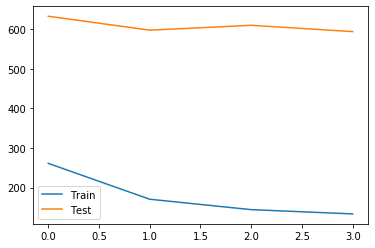

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])

Plotting the errors for each field below shows that the 'y' coordinates for each figure generally have the largest error and the errors growing rapidly approaching the tips of the fingers.

In [35]:
preds = model.predict(features)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

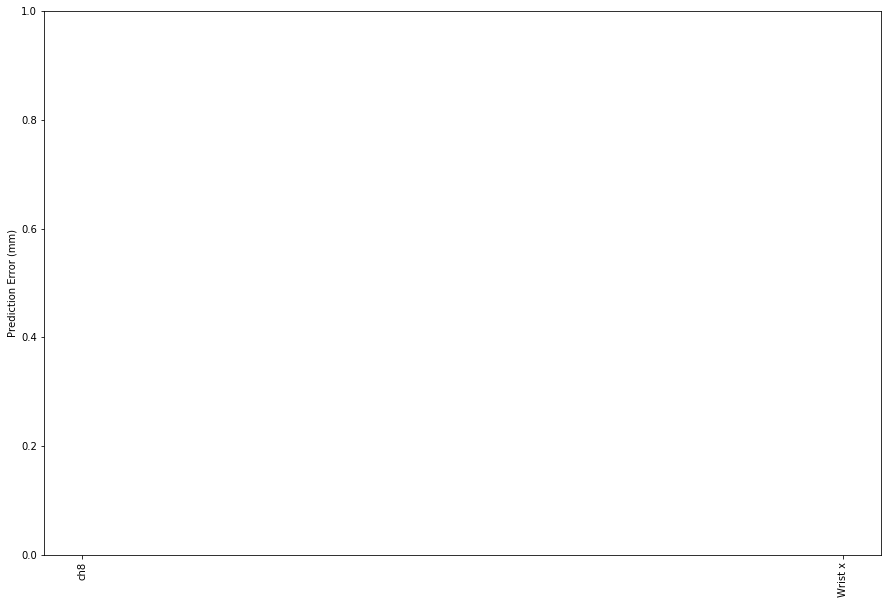

In [36]:
error = labels - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:], avg_error)
for i in range(0,63,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

## LSTM with Fully Connected Layers
Below is a test using a model with several dense layers after the LSTM layers, instead of using the pretrained autoencoder.

In [27]:
model_fc = tf.keras.models.Sequential()
model_fc.add(LSTM(64, return_sequences=True, input_shape=(seq_length, 8)))
model_fc.add(Dropout(0.2))
model_fc.add(LSTM(64))
model_fc.add(BatchNormalization())
model_fc.add(Dense(100, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.2))
model_fc.add(Dense(64, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(Dropout(0.2))
model_fc.add(Dense(63, input_dim=64))

model_fc.compile(optimizer='Adam', loss='mse')

history = model_fc.fit(features, labels, batch_size=seq_length, epochs=5, verbose=1, validation_split=0.2)

Train on 13160 samples, validate on 3290 samples
Epoch 1/5
13160/13160 [==============================] - 25s 2ms/sample - loss: 446.7564 - val_loss: 101.6531
Epoch 2/5
 6592/13160 [==============>...............] - ETA: 10s - loss: 118.3758

KeyboardInterrupt: 

In [28]:
model_fc.save('FC_model_jose_finger_4.h5')

### Visual Model Error

In [26]:
preds = model_fc.predict(features)

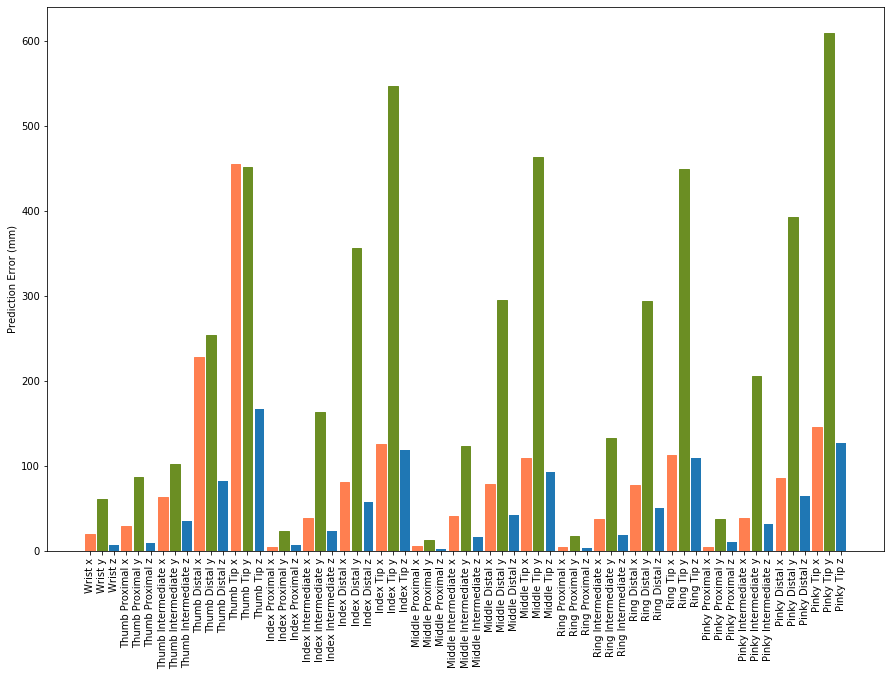

In [27]:
error = labels - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:], avg_error)
for i in range(0,63,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

## Training the Model On Tips Only
In an attempt to improve the accuracy of prediction of the fingertips the above models are modified and trained only using the fingertip position data to understand if this simplification yields an improvement. This is done on both of the architectures tested above.

### Autoencoder Architecture

In [29]:
encoding_dim = 9 #dimensionality of 'feature' vector

a_fn = None

# Full autoencoder
input_vec = Input(shape=(18,))
dense_0 = Dense(32, activation=a_fn)(input_vec)
dense_1 = Dense(16, activation=a_fn)(dense_0)
encoded = Dense(encoding_dim, activation=a_fn)(dense_1)
dense_2 = Dense(32, activation=a_fn, name='decoder_0')(encoded)
dense_3 = Dense(16, activation=a_fn, name='decoder_1')(dense_2)
decoded = Dense(18, activation=a_fn, name='decoder_output')(dense_3)

autoencoder = Model(input_vec, decoded)

# Encoder from autoencoder
encoder = Model(input_vec, encoded)

# Decoder from autoencoder layers
decoder_input = Input(shape=(encoding_dim,), name='encoded_input')
decode_0 = autoencoder.layers[-3](decoder_input)
decode_1 = autoencoder.layers[-2](decode_0)
decode_output = autoencoder.layers[-1](decode_1)
decoder = Model(decoder_input, decode_output, name='decoder')

# Train Autoencoder
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

In [30]:
label_ar_t = label_ar[:,[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]]
label_ar_t.shape

(16481, 18)

In [31]:
ret = autoencoder.fit(label_ar_t, label_ar_t, batch_size=512, epochs=30, verbose=1, validation_split=0.2)

Train on 13184 samples, validate on 3297 samples
Epoch 1/30
13184/13184 [==============================] - 2s 125us/sample - loss: 1804.8644 - val_loss: 844.6304
Epoch 2/30
13184/13184 [==============================] - 0s 6us/sample - loss: 363.1596 - val_loss: 143.7439
Epoch 3/30
13184/13184 [==============================] - 0s 6us/sample - loss: 108.8713 - val_loss: 135.5584
Epoch 4/30
13184/13184 [==============================] - 0s 6us/sample - loss: 84.1743 - val_loss: 121.3580
Epoch 5/30
13184/13184 [==============================] - 0s 6us/sample - loss: 70.7524 - val_loss: 107.9477
Epoch 6/30
13184/13184 [==============================] - 0s 7us/sample - loss: 59.9721 - val_loss: 100.2388
Epoch 7/30
13184/13184 [==============================] - 0s 6us/sample - loss: 51.1394 - val_loss: 91.6366
Epoch 8/30
13184/13184 [==============================] - 0s 6us/sample - loss: 44.0869 - val_loss: 85.8753
Epoch 9/30
13184/13184 [==============================] - 0s 6us/sample - l

Create a smaller labels vector with only the tip and wrist x,y,z:

In [31]:
labels_tip = labels[:,[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]]
labels_tip.shape

(89004, 18)

In [32]:
#lstm layers
inputs = Input(shape=(None, 8), name="inputs")
lstm_0 = LSTM(64, return_sequences=True, name="lstm_0")(inputs)
do = Dropout(0.2)(lstm_0)
lstm_1 = LSTM(64, return_sequences=False, name="lstm_1")(do)
lstm_out = Dense(9, activation=None, name="lstm_out")(lstm_1)

#decoder layers
decoder_0 = decoder.get_layer("decoder_0")(lstm_out)
decoder_0.trainable = False
decoder_1 = decoder.get_layer("decoder_1")(decoder_0)
decoder_1.trainable = False
decoder_output = decoder.get_layer("decoder_output")(decoder_1)
decoder_output.trainable = False

model = Model(inputs, decoder_output, name="model_v1")
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "model_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, None, 8)]         0         
_________________________________________________________________
lstm_0 (LSTM)                (None, None, 64)          18688     
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
lstm_out (Dense)             (None, 9)                 585       
_________________________________________________________________
decoder_0 (Dense)            (None, 32)                320       
_________________________________________________________________
decoder_1 (Dense)            (None, 16)                528

In [33]:
history = model.fit(features, labels_tip, batch_size=seq_length, epochs=4, verbose=1, validation_split=0.2)

Train on 71203 samples, validate on 17801 samples
Epoch 1/4
71203/71203 [==============================] - 88s 1ms/sample - loss: 371.7387 - val_loss: 296.5638
Epoch 2/4
71203/71203 [==============================] - 81s 1ms/sample - loss: 258.2415 - val_loss: 275.9274
Epoch 3/4
71203/71203 [==============================] - 77s 1ms/sample - loss: 218.4306 - val_loss: 257.8691
Epoch 4/4
71203/71203 [==============================] - 82s 1ms/sample - loss: 194.0974 - val_loss: 247.3258


### Visual Model Error
Model error for the reduced Autoencoder architecture:

In [34]:
preds = model.predict(features)

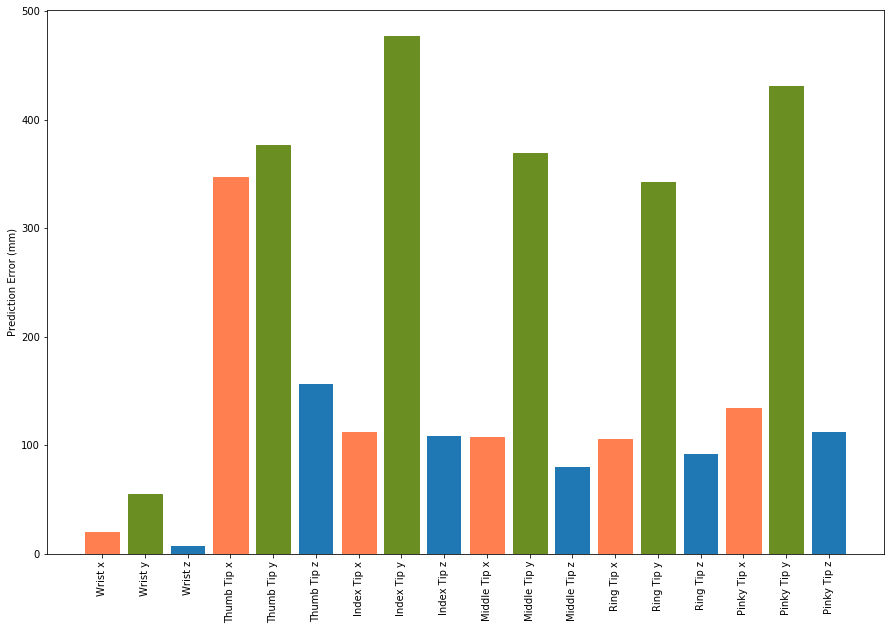

In [35]:
error = labels_tip - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:][[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]], avg_error)
for i in range(0,18,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

### Tips only with FC Architecture

In [68]:
model_fc = tf.keras.models.Sequential()
model_fc.add(LSTM(64, return_sequences=True, input_shape=(seq_length, 8)))
model_fc.add(Dropout(0.2))
model_fc.add(LSTM(64))
model_fc.add(BatchNormalization())
model_fc.add(Dense(100, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.2))
model_fc.add(Dense(64, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(Dropout(0.2))
model_fc.add(Dense(18, input_dim=64))

model_fc.summary()
model_fc.compile(optimizer='Adam', loss='mse')

history = model_fc.fit(features, labels_tip, batch_size=seq_length, epochs=9, verbose=1, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 64)            18688     
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
batch_normalization_v1_8 (Ba (None, 64)                256       
_________________________________________________________________
dense_4 (Dense)              (None, 100)               6500      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
batch_normalization_v1_9 (Ba (None, 100)               400       
__________

NameError: name 'labels_tip' is not defined

### Visual Model Error
A similar visualizion is now done on this new more restricted model. These errors show 20% - 25% improvement on fingertip y position.

In [37]:
preds = model_fc.predict(features)

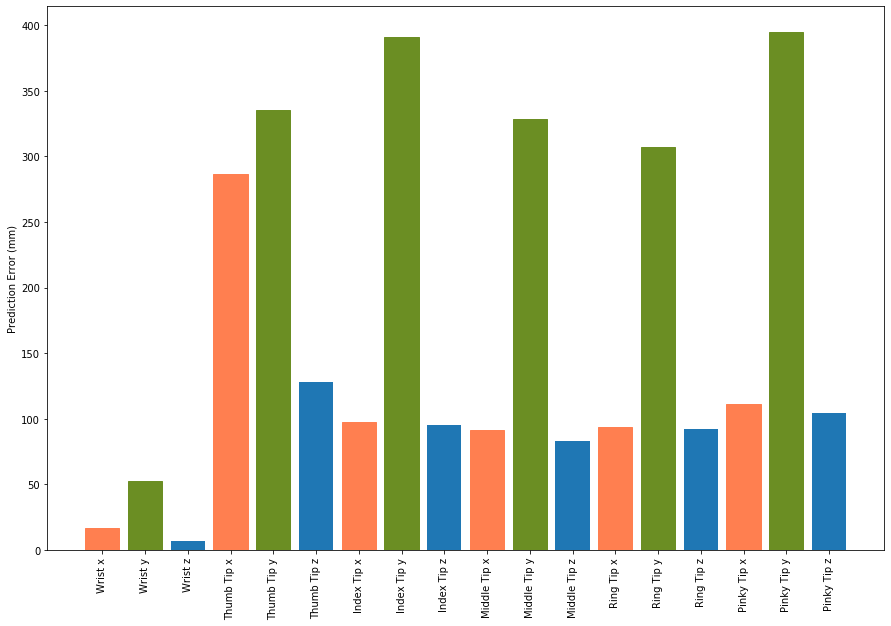

In [38]:
error = labels_tip - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:][[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]], avg_error)
for i in range(0,18,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()